In [10]:
#dependency install
# %pip install pandas
# %pip install openpyxl

In [11]:
#imports
import csv
import pandas as pd
import hw0
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

In [12]:
NAN = float("nan")

In [13]:
class HierarchicalClusteringHW1(hw0.HierarchicalClustering):
    def __init__(self, cluster_dist, silh_fun, return_distances=False, return_for_dendrogram=False):
        # the function that measures distances clusters (lists of data vectors)
        self.cluster_dist = cluster_dist

        # if the results of run() also needs to include distances;
        # if true, each joined pair in also described by a distance.
        self.return_distances = return_distances
        self.return_for_dendrogram = return_for_dendrogram
        self.silh_fun = silh_fun

    def run(self, data):
        """
        Performs hierarchical clustering until there is only a single cluster left
        and return a recursive structure of clusters.
        """

        # clusters stores current clustering. It starts as a list of lists
        # of single elements, but then evolves into lists like
        # [[["Albert"], [["Branka"], ["Cene"]]], [["Nika"], ["Polona"]]]
        clusters = [[name] for name in data.keys()]

        if self.return_for_dendrogram:
            linkages = []

        if self.return_for_dendrogram:
            avgSilhs = []
            avgSilhs.append((len(clusters), self.silh_fun(data, clusters)))

        while len(clusters) >= 2:
            first, second, distance = self.closest_clusters(data, clusters)
            # update the "clusters" variable

            if self.return_for_dendrogram:
                linkages.append([first, second, distance, 2])
            
            firstIndex, secondIndex = clusters.index(first), clusters.index(second)
            if self.return_distances:
                newClusters = [ [clusters[firstIndex], clusters[secondIndex], distance] ]
            else:
                newClusters = [ [clusters[firstIndex], clusters[secondIndex]] ]
            for cluster in clusters:
                if cluster == first or cluster == second: continue
                newClusters.append(cluster)
            clusters = newClusters

            if self.return_for_dendrogram:
                avgSilhs.append((len(clusters), self.silh_fun(data, clusters)))

        return (clusters,) if not self.return_for_dendrogram else (clusters, linkages, avgSilhs) 

In [14]:
def silhouette(el, clusters, data):
    """
    Za element el ob podanih podatkih data (slovar vektorjev) in skupinah
    (seznam seznamov nizov: ključev v slovarju data) vrni silhueto za element el.
    """

    if len(clusters) < 2: return NAN

    distanceFunc = hw0.euclidean_dist
    linkageFunc = hw0.average_linkage

    # find out what cluster contains the element
    belongId = None
    for i in range(len(clusters)):
        flatClusterI = hw0.flatten(clusters[i])
        if el in flatClusterI: 
            belongId = i
            break
    
    elData = data[el]

    # calc a
    aDistances = []
    flatClusterBI = hw0.flatten(clusters[belongId])
    for clusterEl in flatClusterBI:
        if clusterEl == el: continue
        ceData = data[clusterEl]
        aDistances.append(distanceFunc(elData, ceData))
    a = sum(aDistances)/len(aDistances) if len(aDistances)>0 else 0
    if a == 0: return 0 # thanks https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=Note%20that%20a(i)%20is%20not%20clearly%20defined%20for%20clusters%20with%20size%20%3D%201%2C%20in%20which%20case%20we%20set

    #calc b
    #   find closest cluster
    closestClusterId = None
    closestClusterDist = None
    for i in range(len(clusters)):
        if i == belongId: continue

        belongCluster = []
        for index in hw0.flatten(clusters[belongId]):
            belongCluster.append(data[index])

        compareCluster = []
        for index in hw0.flatten(clusters[i]):
            compareCluster.append(data[index])

        distance = linkageFunc(belongCluster, compareCluster, distanceFunc)
        if closestClusterDist is None or distance < closestClusterDist:
            closestClusterDist = distance
            closestClusterId = i
    
    bDistances = []
    for clusterEl in hw0.flatten(clusters[closestClusterId]):
        ceData = data[clusterEl]
        bDistances.append(distanceFunc(elData, ceData))
    b = sum(bDistances)/len(bDistances)

    s = (b - a) / max(a, b) if max(a, b) != 0 else NAN
    return s


def silhouette_average(data, clusters):
    """
    Za podane podatke (slovar vektorjev) in skupine (seznam seznamov nizov:
    ključev v slovarju data) vrni povprečno silhueto.
    """
    dataKeys = list(data.keys())
    silhs = []
    for key in dataKeys:
        calculatedSilh = silhouette(key, clusters, data)
        if calculatedSilh == calculatedSilh:
            silhs.append(silhouette(key, clusters, data))
    avgS = sum(silhs)/len(silhs) if len(silhs) > 0 else NAN
    
    return avgS

### Reading the data

In [15]:
# #read CSV
# rawDataHeader = []
# rawData = []
# with open("eurovision_song_contest_1957_2023.csv") as csvfile:
#     reader = csv.reader(csvfile, delimiter=",")
#     rawDataHeader = next(reader)
#     for row in reader:
#         rawData.append(row)

In [16]:
pathOriginalDataFile = "data/eurovision_song_contest_1957_2023.xlsx"
origDataFrame = pd.read_excel(pathOriginalDataFile)

In [17]:
origDataFrame.keys()[6]

'Points      '

In [18]:
#fixing this bug-inducing column/attribute name
oldkey = origDataFrame.keys()[6]
newkey = origDataFrame.keys()[6].rstrip()
print("\"{}\"".format(oldkey))
print("\"{}\"".format(newkey))
origDataFrame.rename(columns={oldkey : newkey}, inplace=True)

"Points      "
"Points"


In [19]:
origDataFrame.keys()[6]

'Points'

## Version 1

### Data preparation

Poskusimo tako, da oblikujemo tabelo, kjer so vrstice glasujoče države, stolpci pa države, za katere so glasovale. V celicah so števila točk glasovanja. Stolpci z glasovi so za vsako leto posebej, leta dodamo tabeli (širimo v desno).

In [20]:
#drop entries that aren't for finals
prep1orig = origDataFrame[origDataFrame["(semi-) final"] == "f"]

In [21]:
prep1years = prep1orig["Year"].unique()
prep1voters = prep1orig["From country"].unique()
prep1votedFor = prep1orig["To country"].unique()

prep1data = {}
for i in range(len(prep1voters)):
    voter = prep1voters[i]
    prep1data[voter] = []

for year in prep1years:
    yearSelection = prep1orig[prep1orig["Year"] == year]
    for voter in prep1voters:
        voterSelection = yearSelection[yearSelection["From country"] == voter]
        newVotes = []
        for votedFor in prep1votedFor:
            lineSelection = voterSelection[voterSelection["To country"] == votedFor]
            newVoteVal = NAN
            if len(lineSelection["Points"].values) > 0:
                newVoteVal = lineSelection["Points"].values[0]
            newVotes.append(newVoteVal)
        prep1data[voter] += newVotes

### Clustering

In [22]:
#params
distance1 = hw0.euclidean_dist
linkage1 = hw0.single_linkage
distFun1 = lambda c1, c2: linkage1(c1, c2, distance1)
silhFun1 = silhouette_average

In [23]:
hc1 = HierarchicalClusteringHW1(distFun1, silhFun1, return_distances=False, return_for_dendrogram=True)
clusters1 = hc1.run(prep1data)

### Visualization

In [24]:
vis1codex = [[v] for v in prep1voters]
linkages1 = clusters1[1]
for line in linkages1:
    if line[0] not in vis1codex:
        vis1codex.append(line[0])
    if line[1] not in vis1codex:
        vis1codex.append(line[1])
    line[0] = vis1codex.index(line[0])
    line[1] = vis1codex.index(line[1])

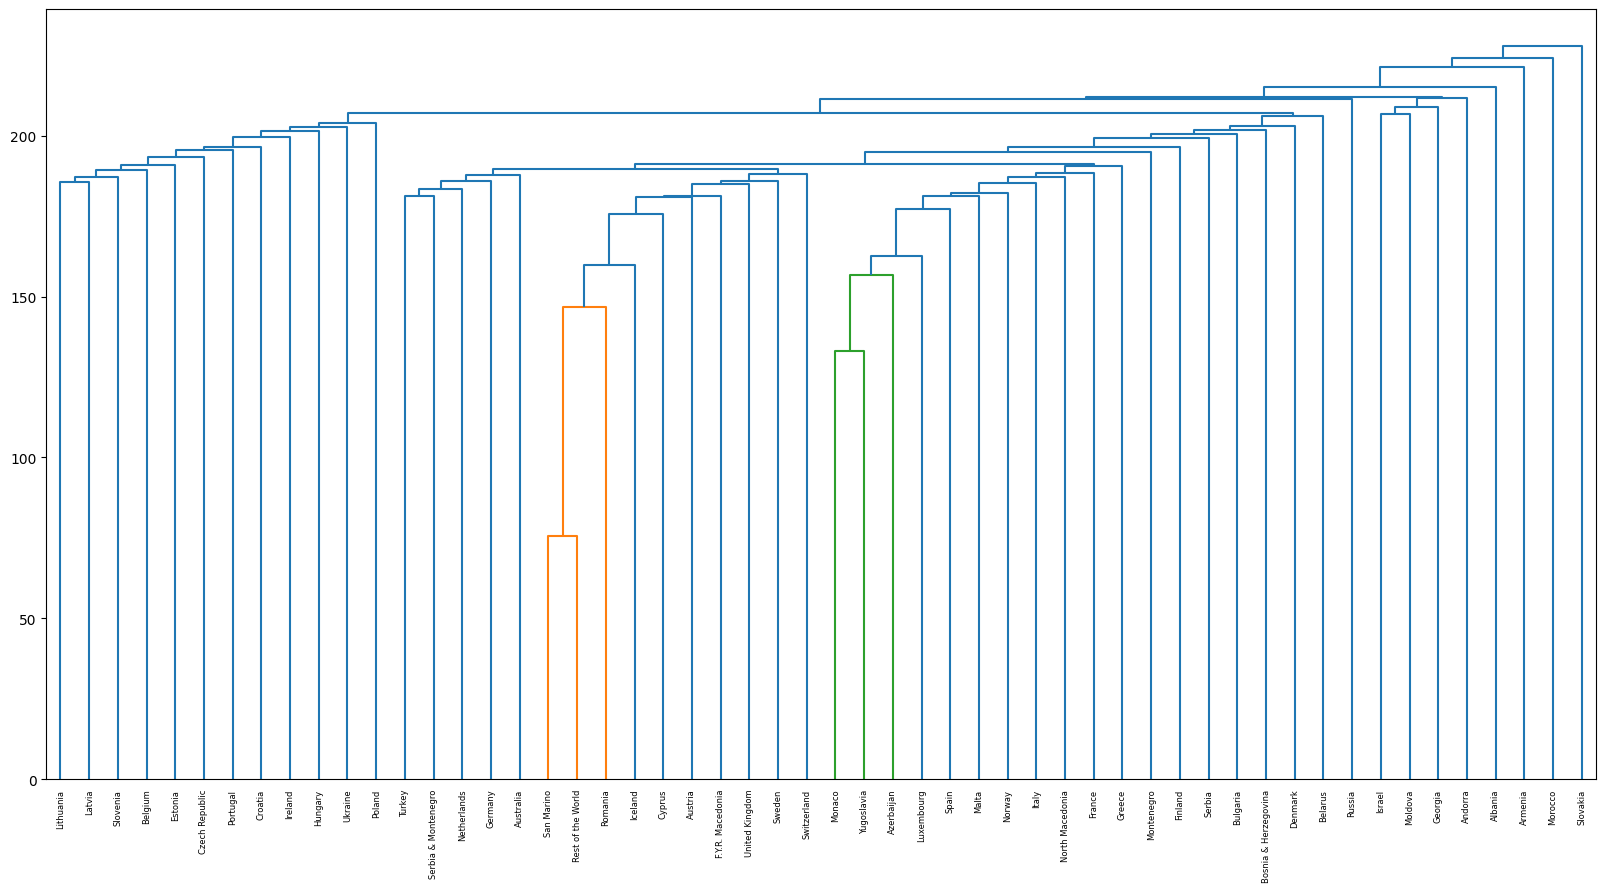

In [25]:
# Plot dendrogram
plt.figure(figsize=(20, 10))
dn1 = hierarchy.dendrogram(linkages1, labels=prep1voters)

# Show plot
plt.show()

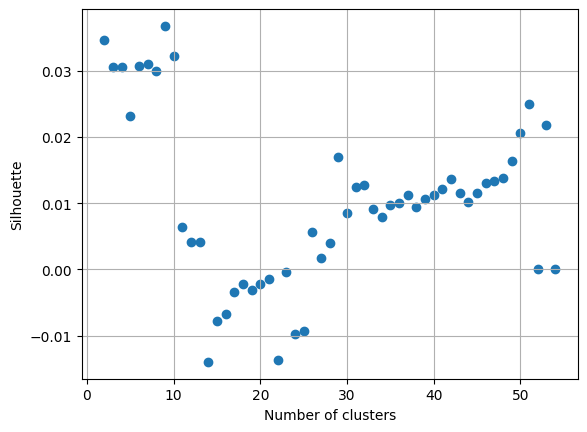

In [26]:
vis1silGraphX, vis1silGraphY = zip(*clusters1[2])

plt.scatter(vis1silGraphX, vis1silGraphY)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.grid(True)
plt.show()

## Version 2

### Data preparation

Poskusimo še tako, da glasove glasujočih držav povprečimo po državah prejemnicah.

In [28]:
prep2orig = origDataFrame[origDataFrame["(semi-) final"] == "f"]

In [29]:
prep2years = prep2orig["Year"].unique()
prep2voters = prep2orig["From country"].unique()
prep2votedFor = prep2orig["To country"].unique()

prep2data = {}
for i in range(len(prep2voters)):
    voter = prep2voters[i]
    prep2data[voter] = [ 0 for c in prep2votedFor ]

for year in prep2years:
    yearSelection = prep2orig[prep2orig["Year"] == year]
    for voter in prep2voters:
        voterSelection = yearSelection[yearSelection["From country"] == voter]
        newVotes = []
        for votedFor in prep2votedFor:
            lineSelection = voterSelection[voterSelection["To country"] == votedFor]
            newVoteVal = NAN
            if len(lineSelection["Points"].values) > 0:
                newVoteVal = lineSelection["Points"].values[0]
            newVotes.append(newVoteVal)
        
        for i in range(len(newVotes)):
            if newVotes[i] == newVotes[i]:
                prep2data[voter][i] = prep2data[voter][i] + newVotes[i]

In [30]:
for voterCountryProfile in prep2data.values():
    for i in range(len(voterCountryProfile)):
        voterCountryProfile[i] /= len(prep2years)

### Clustering

In [31]:
distance2 = hw0.euclidean_dist
linkage2 = hw0.single_linkage
distFun2 = lambda c1, c2: linkage2(c1, c2, distance2)
silhFun2 = silhouette_average

In [32]:
hc2 = HierarchicalClusteringHW1(distFun2, silhFun2, return_distances=False, return_for_dendrogram=True)
clusters2 = hc2.run(prep2data)

### Visualization

In [33]:
vis2codex = [[v] for v in prep2voters]
linkages2 = clusters2[1]
for line in linkages2:
    if line[0] not in vis2codex:
        vis2codex.append(line[0])
    if line[1] not in vis2codex:
        vis2codex.append(line[1])
    line[0] = vis2codex.index(line[0])
    line[1] = vis2codex.index(line[1])

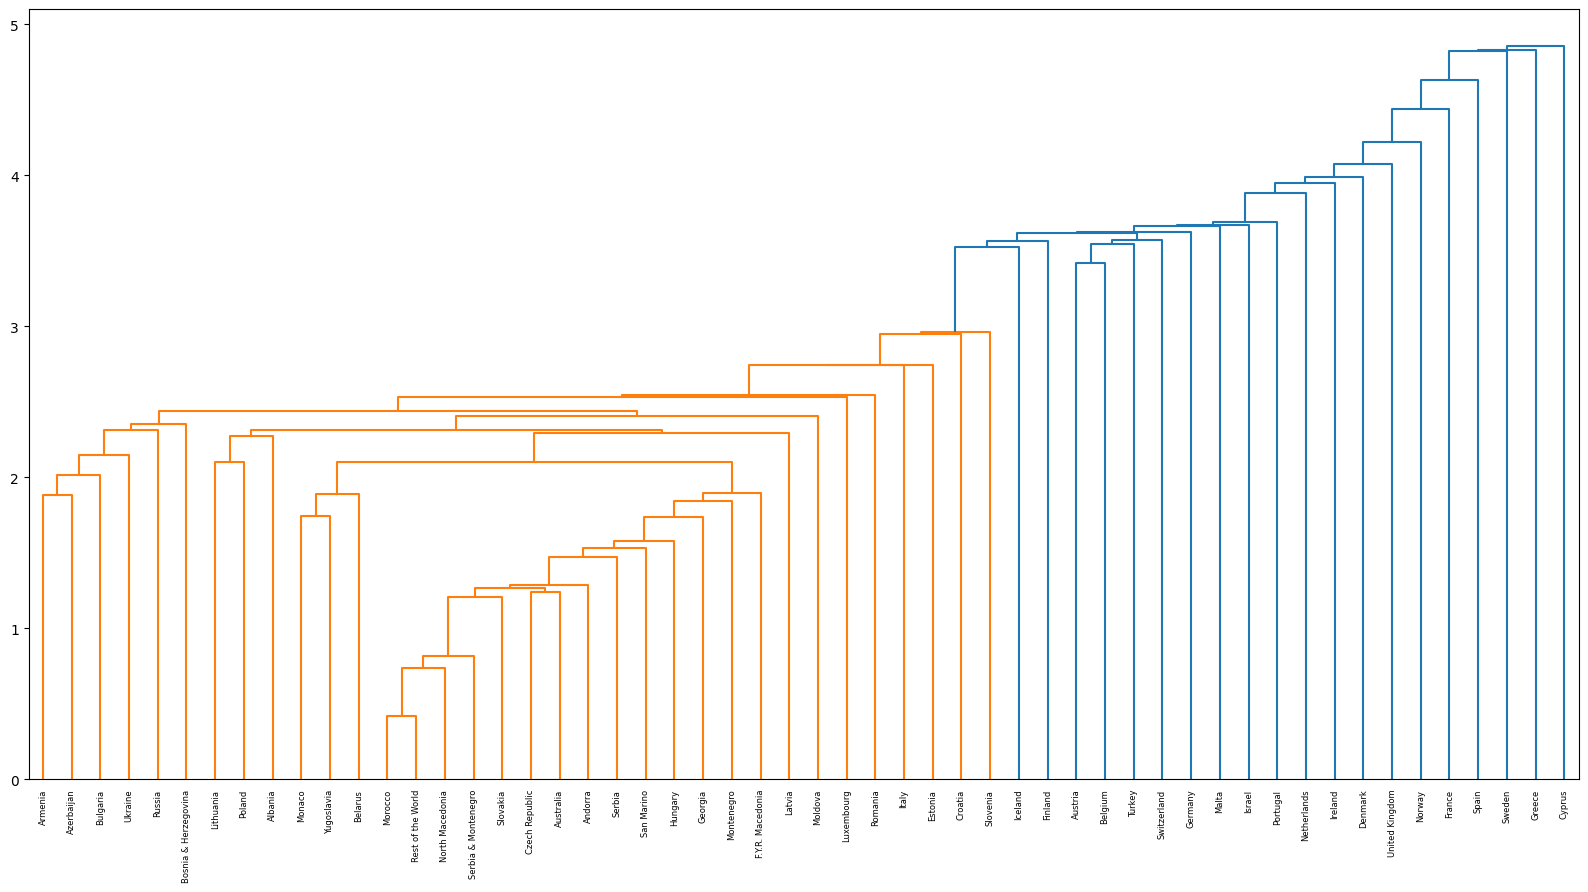

In [34]:
plt.figure(figsize=(20, 10))
dn2 = hierarchy.dendrogram(linkages2, labels=prep2voters)
plt.show()

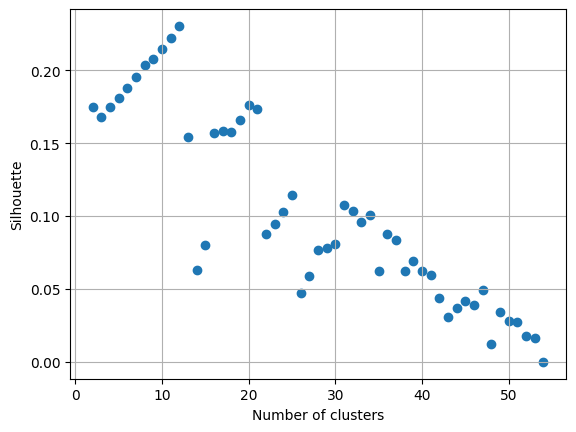

In [35]:
vis2silGraphX, vis2silGraphY = zip(*clusters2[2])

plt.scatter(vis2silGraphX, vis2silGraphY)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.grid(True)
plt.show()

### Version 3

Poskusimo še enkrat z načinom iz prve verzije, vendar omejimo nabor let, saj se v skoraj 70 letih situacije lahko popolnoma spremenijo.

In [52]:
#drop entries that aren't for finals
prep3orig = origDataFrame[origDataFrame["(semi-) final"] == "f"]

In [53]:
prep3years = range(2000,2020)
prep3orig = prep3orig[prep3orig["Year"] >= 2000]
prep3orig = prep3orig[prep3orig["Year"] <= 2019]
prep3voters = prep3orig["From country"].unique()
prep3votedFor = prep3orig["To country"].unique()

prep3data = {}
for i in range(len(prep3voters)):
    voter = prep3voters[i]
    prep3data[voter] = []

for year in prep3years:
    yearSelection = prep3orig[prep3orig["Year"] == year]
    for voter in prep3voters:
        voterSelection = yearSelection[yearSelection["From country"] == voter]
        newVotes = []
        for votedFor in prep3votedFor:
            lineSelection = voterSelection[voterSelection["To country"] == votedFor]
            newVoteVal = NAN
            if len(lineSelection["Points"].values) > 0:
                newVoteVal = lineSelection["Points"].values[0]
            newVotes.append(newVoteVal)
        prep3data[voter] += newVotes

### Clustering

In [54]:
#params
distance3 = hw0.euclidean_dist
linkage3 = hw0.single_linkage
distFun3 = lambda c1, c2: linkage1(c1, c2, distance3)
silhFun3 = silhouette_average

In [55]:
hc3 = HierarchicalClusteringHW1(distFun3, silhFun3, return_distances=False, return_for_dendrogram=True)
clusters3 = hc3.run(prep3data)

### Visualization

In [56]:
vis3codex = [[v] for v in prep3voters]
linkages3 = clusters3[1]
for line in linkages3:
    if line[0] not in vis3codex:
        vis3codex.append(line[0])
    if line[1] not in vis3codex:
        vis3codex.append(line[1])
    line[0] = vis3codex.index(line[0])
    line[1] = vis3codex.index(line[1])

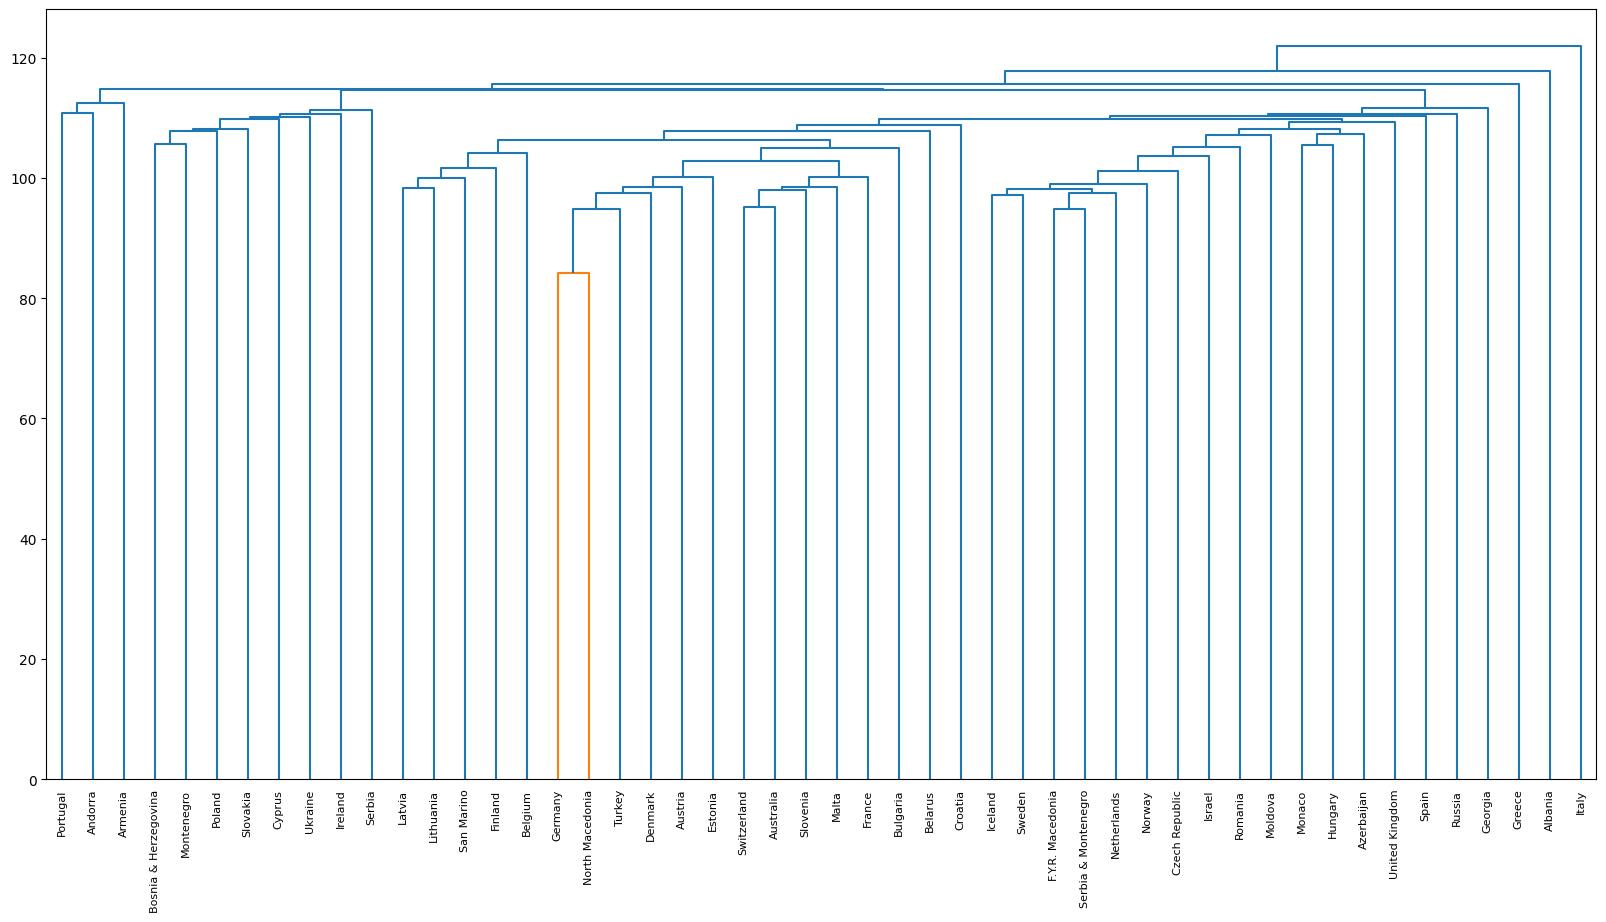

In [57]:
plt.figure(figsize=(20, 10))
dn3 = hierarchy.dendrogram(linkages3, labels=prep3voters)
plt.show()

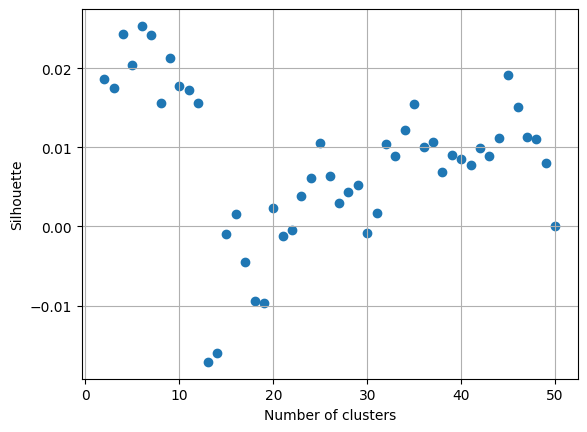

In [58]:
vis3silGraphX, vis3silGraphY = zip(*clusters3[2])

plt.scatter(vis3silGraphX, vis3silGraphY)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.grid(True)
plt.show()

## Version 4

Poskusimo z 2000 do 2008.

In [59]:
prep4orig = origDataFrame[origDataFrame["(semi-) final"] == "f"]
prep4years = range(2000,2009)
prep4orig = prep4orig[prep4orig["Year"] >= 2000]
prep4orig = prep4orig[prep4orig["Year"] <= 2008]
prep4voters = prep4orig["From country"].unique()
prep4votedFor = prep4orig["To country"].unique()

prep4data = {}
for i in range(len(prep4voters)):
    voter = prep4voters[i]
    prep4data[voter] = []

for year in prep4years:
    yearSelection = prep4orig[prep4orig["Year"] == year]
    for voter in prep4voters:
        voterSelection = yearSelection[yearSelection["From country"] == voter]
        newVotes = []
        for votedFor in prep4votedFor:
            lineSelection = voterSelection[voterSelection["To country"] == votedFor]
            newVoteVal = NAN
            if len(lineSelection["Points"].values) > 0:
                newVoteVal = lineSelection["Points"].values[0]
            newVotes.append(newVoteVal)
        prep4data[voter] += newVotes

### Clustering

In [61]:
#params
distance4 = hw0.euclidean_dist
linkage4 = hw0.single_linkage
distFun4 = lambda c1, c2: linkage1(c1, c2, distance4)
silhFun4 = silhouette_average

In [62]:
hc4 = HierarchicalClusteringHW1(distFun4, silhFun4, return_distances=False, return_for_dendrogram=True)
clusters4 = hc4.run(prep4data)

### Visualization

In [63]:
vis4codex = [[v] for v in prep4voters]
linkages4 = clusters4[1]
for line in linkages4:
    if line[0] not in vis4codex:
        vis4codex.append(line[0])
    if line[1] not in vis4codex:
        vis4codex.append(line[1])
    line[0] = vis4codex.index(line[0])
    line[1] = vis4codex.index(line[1])

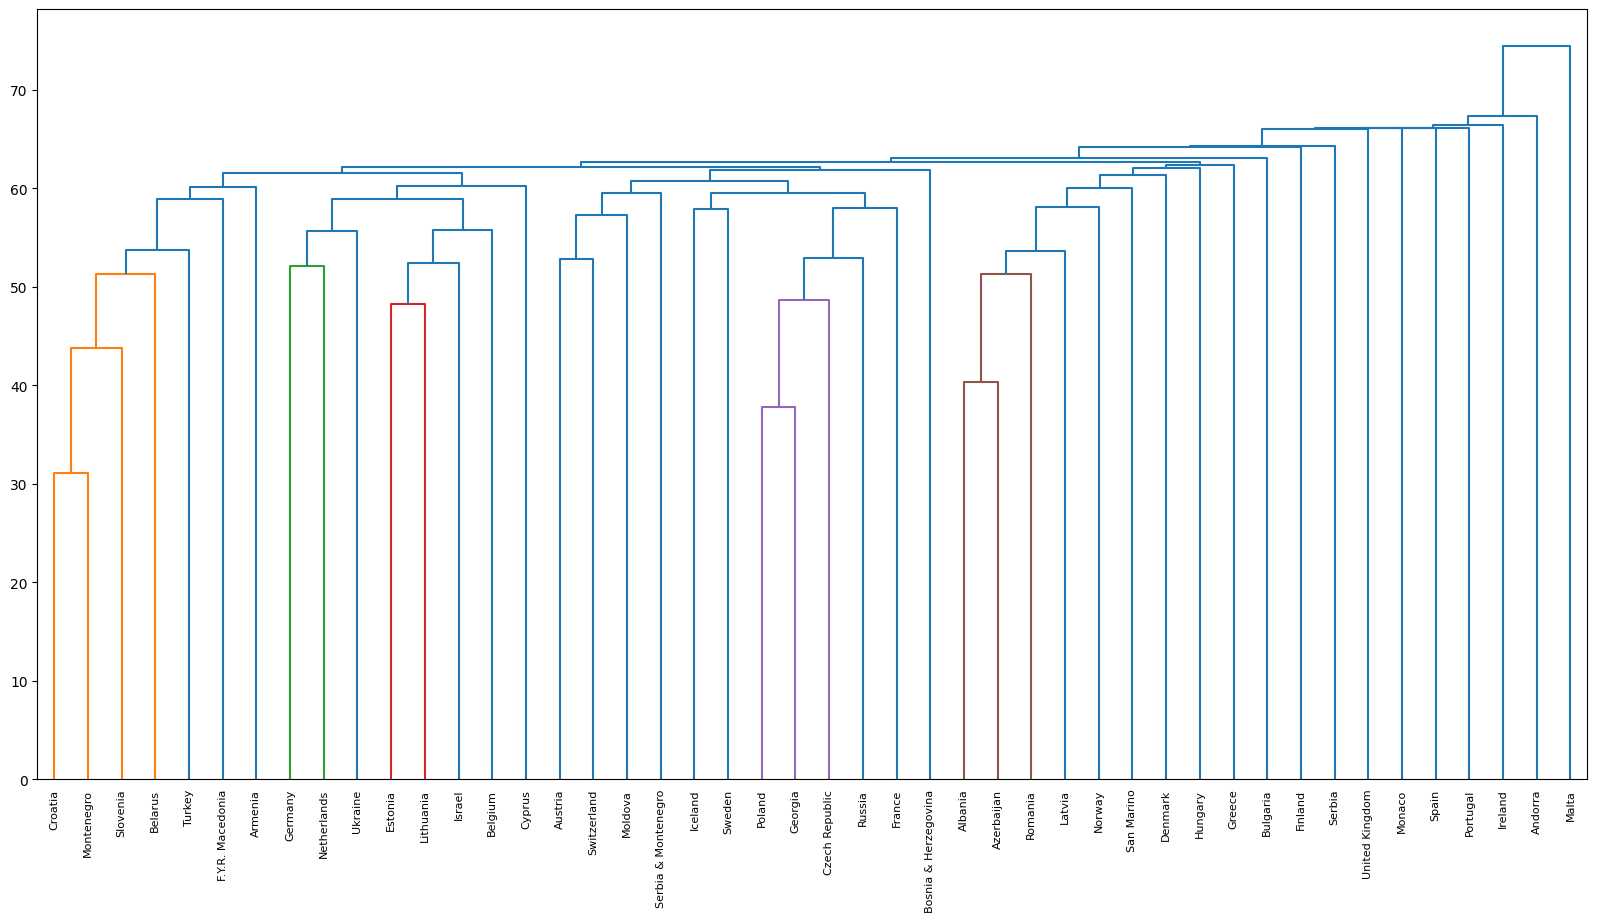

In [64]:
plt.figure(figsize=(20, 10))
dn4 = hierarchy.dendrogram(linkages4, labels=prep4voters)
plt.show()

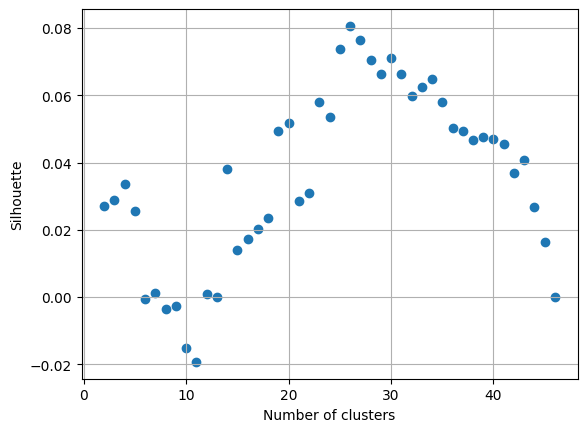

In [65]:
vis4silGraphX, vis4silGraphY = zip(*clusters4[2])

plt.scatter(vis4silGraphX, vis4silGraphY)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette')
plt.grid(True)
plt.show()